In this jupyter notebook the case-study is developed which is to be submitted to ADHS 2018.

**First**, we take a look at the labelling and the properties of interest.
We label identify two regions, 
 1. region **A** populated either with a highly desired product or with sand.
 2. region **B** populated with a moderately desired product.


Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


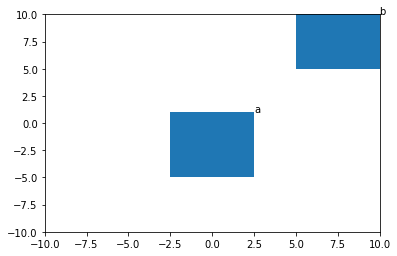

In [1]:
import polytope as pc
import numpy as np
import matplotlib.patches
import matplotlib.pyplot as plt

from ApprxSimulation.LTI_simrel import tune_dratio, eps_err
from ApprxSimulation.Visualize import plot_regions, patch_ellips, ellips_cov
from Models.MDP import Rpol
from label_abstraction.test_mdp import test_mdp_dfsa, formula_to_mdp, test_ltl_synth2
# Import packages:
from Models.Linear import LTI, POMDP
from label_abstraction.mdp import *
import polytope as pc
import numpy as np
import ApprxSimulation.Visualize as Vis
science_regions = dict()
science_regions['a'] = pc.box2poly(np.array([[-2.5, 2.5],[-5, 1]]))
science_regions['b'] = pc.box2poly(np.array([[5, 10],[5, 10]]))
Vis.plot_regions(science_regions, [-10,10], [-10,10], tikz=True) 


Initialise the dynamics


In [2]:
# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2)  #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[.4,-0.2],[-0.2,0.4]])  
# noise on state transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])
# defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None


Initialize the sensor model

In [3]:

# Sensor noise => pomdp
H = np.eye(2) #np.ones((1,2)) # what can be measured
V = 1*np.eye(2)
    #  x^+= A x + Bu + w
    #  y = C x
    #  z = H x+v

P = np.eye(2)
mean = np.zeros((2,1))
pomdp = POMDP(sys_lti, H, V, P, mean)

L, Pst = pomdp.kalman()
print(Pst)
belief_mdp = pomdp.beliefmodel()



[[ 0.84446 -0.2862 ]
 [-0.2862   0.84446]]


Compute simplified simple  with continuous state.

x(k+1) = A x(k) + B u(k) + **P** C^T s(k+1) 
with

 variance s ~ N(0,**S_inv**). 

 1. Define an initial P, and compute an upper and lower bound on P_k based on this initial P and the steady state P.
1. Compute **S_inv** such that forall k: **S_inv**=< S_k^{-1}
1. Compute the error caused by the stochastic difference between this simple LTI and the time varying kalman LTI

In [4]:
P_init = Pst-np.eye(2)*.1
P_l =Pst-np.eye(2)*.1
P_upper =Pst #+np.eye(2)*.1

lti_belief, Error_noise,error_rank = belief_mdp.to_LTI_approx(C, P_init, P_l,P_upper, combined =False)
print Error_noise, error_rank
print(lti_belief)

P_l is a valid lower bound
P_up is a valid upper bound
(0.080108827884598083, 0.17189243466963675) (2, 2)
<Models.Linear.LTI instance at 0x1053e7638>


Compute a polytope that over aproximates the error in the stochastic noise for a 2 dimensional system


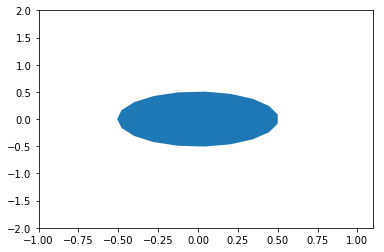

In [5]:
import math
A = np.block([[ np.array([[math.cos(a), math.sin(a)]])] for a in np.linspace(0,2*math.pi,20)])
ball = pc.Polytope(A=A,b=np.ones((20,1)))

fig = plt.figure()
ax = fig.add_subplot(111)
 
x = pc.extreme(ball)

patch = matplotlib.patches.Polygon(.5*x)
ax.add_patch(patch)
# 

plt.xlim([-1,1.1])
plt.ylim([-2,2])

plt.show()

**Retrieve normalized system**
1. define state space
2. define  input space
3. normalize system


In [6]:

# Define spaces
lti_belief.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-3, 3]])))) # continuous set of inputs
lti_belief.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space


lti_belief_n = lti_belief.normalize()

**Compute probability**



In [1]:
from scipy.stats import chi2

print(Error_noise)
def tradeoff(alpha,delta,ranks,errors,):
    er1 = chi2.ppf([1-alpha*delta],ranks[0])
    er2 = chi2.ppf([1-(1-alpha)*delta],ranks[1])
    val =  (er1**.5)*errors[0]+(er2**.5)*errors[1]
    return val


import scipy.optimize
delta = .01
minimum = scipy.optimize.fmin(lambda alpha : tradeoff(alpha, delta, error_rank,Error_noise ),.7,
                    xtol=0.000001, ftol=0.000001)

print(minimum)

NameError: name 'Error_noise' is not defined

**Compute the Eps,delta error**
Given an delta error and the corresponding polytopic disturbance compute the error

In [8]:
from ApprxSimulation.LTI_simrel import eps_err_dist, eps_err_dist_tuned
grid = pc.box2poly(np.diag([0.5,.5]).dot(np.array([[-1,1],[-1, 1]])))
rad = 0.814549
dist = pc.Polytope(A =ball.A,b=rad*ball.b)
    
# eps_err_dist(lti_belief,grid,dist)
d,M_min, K_min, eps_min = eps_err_dist_tuned(lti_belief_n,grid,dist)


Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.



/anaconda/envs/Py_gdtl/lib/python2.7/site-packages/scipy/optimize/optimize.py:1684: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)



Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.




Maximum number of function evaluations exceeded --- increase maxfun argument.



status: optimal
optimal epsilon 1.26433345788
optimal M [[ 1.04587 -0.02226]
 [-0.02226  1.0108 ]]
Optimal K [[ 0.61837 -0.66405]
 [-0.67635 -0.72203]]


**grid normalised process**


**Define formula and compute DFA//NFA**

In [9]:
print('3.  Grid Gaussian process')

print(lti_belief_n.W)
print(lti_belief_n.T2x)
mdp_grid = lti_belief_n.abstract_io(d, un=7, Accuracy=False, verbose=False)  # do the gridding
print('--- done gridding')
mdp_grid.eps=eps_min
mdp_grid.M = M_min
mdp_grid.K = K_min

3.  Grid Gaussian process
[[ 0.6  0. ]
 [ 0.   0.2]]
[[-0.70711  0.70711]
 [ 0.70711  0.70711]]
Warning no inputspace given
Warning no state space given


((1756, 49), (49, 1756, 1756))
--- done gridding


**Define formula and compute DFA//NFA**

In [21]:

print('4.  Define formula and compute DFA')

#formula = '( ( ! avoid U target ) & ( F avoid ) )'
formula = '( ( F a ) & ( F b ) )'

# figure out a map dict_input2prop from numeric inputs to name based inputs
dfsa, init, final, dict_input2prop = formula_to_mdp(formula)

mdp_grid.map_dfa_inputs(dict_input2prop, science_regions)
mdp_grid.setdfa(dfsa,final)
mat=mdp_grid.act_inputs
np.sum(mdp_grid.act_inputs==0,axis=1)

4.  Define formula and compute DFA
& F a F b
['a', 'b']
{0: (), 1: ('a',), 2: ('b',), 3: ('a', 'b')}
set([1])
('check norm of rows', matrix([[ 0.94199,  0.33563],
        [-0.31952,  0.94758],
        [-0.94199, -0.33563],
        [ 0.31952, -0.94758]]))
('check norm of rows', matrix([[ 0.94199,  0.33563],
        [-0.31952,  0.94758],
        [-0.94199, -0.33563],
        [ 0.31952, -0.94758]]))


[[ 1.  1.  1. ...,  1.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


array([  32, 1626, 1644, 1756])

In [22]:

print('5. Compute recursions')

mdp_grid.policy= None
mdp_grid.trans_qs = None
V, policy, W = mdp_grid.reach_dfa(recursions = 10,delta=delta)


5. Compute recursions


In [23]:
pol = None
pol = Rpol(mdp_grid, V, W, policy)

pol.set_regions(dict_input2prop, science_regions)


In [24]:
print('6. Plot normalized system')
fig = plt.figure()

xi, yi = np.meshgrid(*mdp_grid.srep)

plt.pcolor(mdp_grid.sedge[0], mdp_grid.sedge[1],  W[:-1].reshape(xi.shape, order='F'))
plt.colorbar()
plt.xlim(np.array([mdp_grid.srep[0][0],mdp_grid.srep[0][-1]]))
plt.ylim(np.array([mdp_grid.srep[1][0],mdp_grid.srep[1][-1]]))
#plt.show()

xi, yi = np.meshgrid(np.linspace(mdp_grid.srep[0][0],mdp_grid.srep[0][-1],10),
                     np.linspace(mdp_grid.srep[1][0],mdp_grid.srep[1][-1],10))


6. Plot normalized system


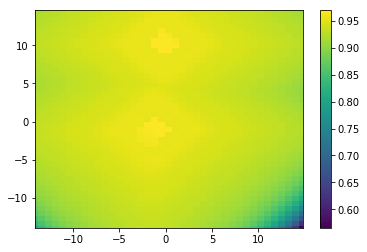

In [25]:

plt.show()


6. Plot concrete systen


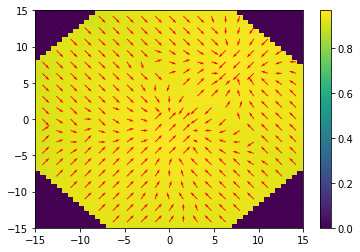

In [26]:
print('6. Plot concrete systen')
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

values = pol.val_concrete(np.block([[xi.flatten()], [yi.flatten()]]))
plt.pcolor(x_edge, y_edge, values.reshape(xi.shape))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

u =sys_lti.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False))
delx = (-np.block([[xi.flatten()],[yi.flatten()]])
        +sys_lti.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
        + sys_lti.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False)))
x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')

plt.show(fig)

In [42]:
# how to get a nice simulation? 
from random import  gauss 
import random
import scipy.linalg as scla
random.seed(a = '4')
print('final state:', final)
time = 50
fig = plt.figure()
ax = fig.add_subplot(111)
x =pc.extreme(science_regions['a'])
y =pc.extreme(science_regions['b'])

patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)
for x0 in (np.array([[0],[-7.5]]),np.array([[-5],[10]])):
    for repeating in range(10):
        pol.state = pol.dfa.init[0]
        
        x = np.zeros((2,time+1))
        x[:,[0]] = x0
        belief_mdp.state =  ( x0,  0*np.eye(2))

        for t in range(time): 
           # x[:,[t+1]] = ( lti_pomdp.a.dot(x[:,[t]])+ lti_pomdp.b.dot(pol(x[:,[t]], transformed=False )) 
           #             + np.array(noise).dot(np.array([[gauss(0,1)],[gauss(0,1)]])))
            (x[:,[t+1]],P) = belief_mdp.simulate(pol(x[:,[t]], transformed=False ))
            
            if pol.state in final :
                print('reached')
                break
            ellips_cov(P, 1, ax, pos =  tuple(x[:,[t+1]].flatten()))
        if not pol.state in final:
            print('not reached')
        plt.plot(x[0,0:t+1],x[1,0:t+1])
        plt.scatter(x[0,0:t+1],x[1,0:t+1], label='Finite states', color='k', s=10, marker="o")          
 


plt.xlabel('x_1') 
plt.ylabel('x_2') 

plt.xlim(np.array([-15,25]))
plt.ylim(np.array([-15,15]))
# Define regions of interest for the labeling
 


('final state:', set([1]))
reached
reached


reached
reached


reached
reached


reached
reached


reached
reached
reached


reached
reached
reached


reached
reached
reached
reached


reached
reached


(-15, 15)

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


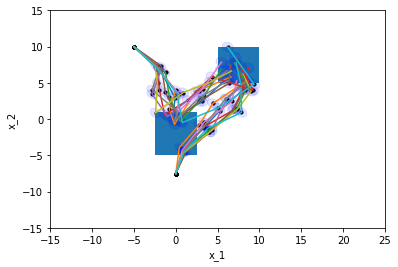

In [43]:
from matplotlib2tikz import save as tikz_save


tikz_save(
    'mytikz.tex',
    figureheight='\\figureheight',
    figurewidth='\\figurewidth'
    )

plt.show()